# Projeto PagBank - Case Aprovação 💳
* **Base de dados:** base_material_apoio (PagBank)
-  Dados: 2000 linhas e 8 colunas
- Bandeira: visa, mastercard, elo
- Status transacao: PAID, DECLINED

---


* **Integrantes do Time:** Thiago Silva Farias
* **Links de Apoio**:
1.   [Normativo 21 ABECS](https://api.abecs.org.br/wp-content/uploads/2019/09/Normativo-021.pdf): detalhes de motivos de recusa das bandeiras/bancos emissores.
2.   [Cartilha Mercado de Meios de Pagamento ABECS](https://api.abecs.org.br/wp-content/uploads/2019/11/Cartilha-da-Abecs-sobre-o-Mercado-de-Meios-de-Pagamento.pdf): informações sobre o funcionamento macro do setor.
3.   [Slides Apresentação](https://docs.google.com/presentation/d/15dJvaY8vaGhhe3b1lkjBEGH2pVvCUniicZCPFSweWIw/edit?usp=sharing): Slide contendo as insights extraidos da base de dados de apoio.
4.   [Dashboard Tableau](https://public.tableau.com/app/profile/thiago.silva.farias/viz/PagBank/PagBank?publish=yes): Dashboard Tableau utilizando base de dados de apoio após o pré-processamento feito por este notebook.




# Importando Base dos Dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_pag_bank = pd.read_csv('base-material-apoio.csv', sep=",")
df_pag_bank['Timestamp'] = pd.to_datetime(df_pag_bank['Timestamp'])
df_pag_bank.head()

,Timestamp,Transacao ID,Data,Valor,Bandeira,Banco Emissor,Mensagem Processamento,Status Transacao
0,2024-01-15 12:15:54,a9ed-be8c63dba0ec,1705320954768,300,visa,Banco do Brasil S.A.,SUCESSO,PAID
1,2024-01-15 12:15:53,a007-ba7b5d929a24,1705320953735,6290,visa,Banco Santander S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED
2,2024-01-15 12:15:52,892f-3eb80eb88649,1705320952511,6390,visa,Banco Bradesco S.A.,SUCESSO,PAID
3,2024-01-15 12:15:51,8852-76d76d57b1b7,1705320951843,5500,mastercard,BANCO SANTANDER (BRASIL) S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED
4,2024-01-15 12:15:51,80b2-e15aaa8d0c3c,1705320951820,6600,mastercard,BANCO CSF S/A,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,DECLINED


# Limpeza da Base de Dados

In [ ]:
# mudando nomes de colunas
df_pag_bank = df_pag_bank.rename(columns={
    "Timestamp": "timestamp",
    "Transacao ID": "transacao_id",
    "Data": "data",
    "Valor": "valor",
    "Bandeira": "bandeira",
    "Banco Emissor": "banco_emissor",
    "Mensagem Processamento": "mensagem_processamento",
    "Status Transacao": "status_transacao"
    })

df_pag_bank.head()

,timestamp,transacao_id,data,valor,bandeira,banco_emissor,mensagem_processamento,status_transacao
0,2024-01-15 12:15:54,a9ed-be8c63dba0ec,1705320954768,300,visa,Banco do Brasil S.A.,SUCESSO,PAID
1,2024-01-15 12:15:53,a007-ba7b5d929a24,1705320953735,6290,visa,Banco Santander S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED
2,2024-01-15 12:15:52,892f-3eb80eb88649,1705320952511,6390,visa,Banco Bradesco S.A.,SUCESSO,PAID
3,2024-01-15 12:15:51,8852-76d76d57b1b7,1705320951843,5500,mastercard,BANCO SANTANDER (BRASIL) S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED
4,2024-01-15 12:15:51,80b2-e15aaa8d0c3c,1705320951820,6600,mastercard,BANCO CSF S/A,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,DECLINED


In [ ]:
# criar coluna reference_month
df_pag_bank['reference_month'] = df_pag_bank['timestamp'].apply(lambda x: pd.to_datetime(f"{x.year}-{x.month}-01"))

In [ ]:
# tratamentos textuais
columns_to_clean = ['bandeira', 'banco_emissor', 'mensagem_processamento', 'status_transacao']

for col in columns_to_clean:
    df_pag_bank[col] = df_pag_bank[col].str.upper().str.strip()

# Substituindo "/" com string vazia
df_pag_bank['banco_emissor'] = df_pag_bank['banco_emissor'].str.replace("/", "", regex=False)

# Substituindo "," com string vazia
df_pag_bank['banco_emissor'] = df_pag_bank['banco_emissor'].str.replace(",", "", regex=False)

# Substituindo "SA" com "S.A."
df_pag_bank['banco_emissor'] = df_pag_bank['banco_emissor'].str.replace(r'\bSA\b', "S.A.", regex=True)

replacements_values = {
    "PORTOSEG S.A. CREDITO FINANCIA": "PORTOSEG S.A. CREDITO FINANCIAMENTO E INVESTIMENTO",
    "BANCO DO ESTADO DO RIO GRANDE": "BANCO DO ESTADO DO RIO GRANDE DO SUL S.A.",
    "REALIZE CREDITO FINANCIAMENTO E INVESTIMENTO S.A .": "REALIZE CREDITO FINANCIAMENTO E INVESTIMENTO S.A.",
    "REALIZE CREDITO FINANCIAMENTO": "REALIZE CREDITO FINANCIAMENTO E INVESTIMENTO S.A."
}

# Replace specified values in 'banco_emissor' column
df_pag_bank['banco_emissor'] = df_pag_bank['banco_emissor'].replace(replacements_values)

# Display the first few rows of the DataFrame
df_pag_bank.head()

,timestamp,transacao_id,data,valor,bandeira,banco_emissor,mensagem_processamento,status_transacao,reference_month
0,2024-01-15 12:15:54,a9ed-be8c63dba0ec,1705320954768,300,VISA,BANCO DO BRASIL S.A.,SUCESSO,PAID,2024-01-01
1,2024-01-15 12:15:53,a007-ba7b5d929a24,1705320953735,6290,VISA,BANCO SANTANDER S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01
2,2024-01-15 12:15:52,892f-3eb80eb88649,1705320952511,6390,VISA,BANCO BRADESCO S.A.,SUCESSO,PAID,2024-01-01
3,2024-01-15 12:15:51,8852-76d76d57b1b7,1705320951843,5500,MASTERCARD,BANCO SANTANDER (BRASIL) S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01
4,2024-01-15 12:15:51,80b2-e15aaa8d0c3c,1705320951820,6600,MASTERCARD,BANCO CSF S.A.,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,DECLINED,2024-01-01


In [ ]:
# criando nova coluna com a categoria da parte do dia (cedo da manhã, manhã, noite, etc)
'''
part_of_day
hora > 4 and hora <= 8: Early Morning (De manhã cedo)
hora > 8 and hora <= 12: Morning (Manhã)
hora > 12 and hora <= 16: Afternoon (Meio-dia)
hora > 16 and hora <= 20: Evening (Anoitecer/Final da Tarde)
hora > 20 and hora <= 24: Night (Noite)
hora <= 4: Late Night (Late Night)
'''

def get_part_of_day(x):
    if 4 < x <= 8:
        return 'Early Morning'
    elif 8 < x < 12:
        return 'Morning'
    elif 12 <= x <= 16:
        return 'Afternoon'
    elif 16 < x <= 20:
        return 'Evening'
    elif 20 < x <= 24:
        return 'Night'
    elif x <= 4:
        return 'Late Night'

df_pag_bank['part_of_day'] = df_pag_bank['timestamp'].dt.hour.apply(get_part_of_day)
df_pag_bank.head()

,timestamp,transacao_id,data,valor,bandeira,banco_emissor,mensagem_processamento,status_transacao,reference_month,part_of_day
0,2024-01-15 12:15:54,a9ed-be8c63dba0ec,1705320954768,300,VISA,BANCO DO BRASIL S.A.,SUCESSO,PAID,2024-01-01,Afternoon
1,2024-01-15 12:15:53,a007-ba7b5d929a24,1705320953735,6290,VISA,BANCO SANTANDER S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01,Afternoon
2,2024-01-15 12:15:52,892f-3eb80eb88649,1705320952511,6390,VISA,BANCO BRADESCO S.A.,SUCESSO,PAID,2024-01-01,Afternoon
3,2024-01-15 12:15:51,8852-76d76d57b1b7,1705320951843,5500,MASTERCARD,BANCO SANTANDER (BRASIL) S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01,Afternoon
4,2024-01-15 12:15:51,80b2-e15aaa8d0c3c,1705320951820,6600,MASTERCARD,BANCO CSF S.A.,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,DECLINED,2024-01-01,Afternoon


In [ ]:
# extraido ano, mes, dia e nome do dia a partir do timestamp
df_pag_bank['year'] = pd.DatetimeIndex(df_pag_bank['timestamp']).year
df_pag_bank['month'] = pd.DatetimeIndex(df_pag_bank['timestamp']).month
df_pag_bank['day'] = pd.DatetimeIndex(df_pag_bank['timestamp']).day
df_pag_bank['day_name'] = df_pag_bank['timestamp'].dt.day_name()

# criando nova coluna com a hora
df_pag_bank['hour'] = pd.Categorical(df_pag_bank['timestamp'].dt.hour, categories=
    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
    ordered=True)
df_pag_bank['minutes'] = df_pag_bank['timestamp'].dt.minute

df_pag_bank.head()

,timestamp,transacao_id,data,valor,bandeira,banco_emissor,mensagem_processamento,status_transacao,reference_month,part_of_day,year,month,day,day_name,hour,minutes
0,2024-01-15 12:15:54,a9ed-be8c63dba0ec,1705320954768,300,VISA,BANCO DO BRASIL S.A.,SUCESSO,PAID,2024-01-01,Afternoon,2024,1,15,Monday,12,15
1,2024-01-15 12:15:53,a007-ba7b5d929a24,1705320953735,6290,VISA,BANCO SANTANDER S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,15
2,2024-01-15 12:15:52,892f-3eb80eb88649,1705320952511,6390,VISA,BANCO BRADESCO S.A.,SUCESSO,PAID,2024-01-01,Afternoon,2024,1,15,Monday,12,15
3,2024-01-15 12:15:51,8852-76d76d57b1b7,1705320951843,5500,MASTERCARD,BANCO SANTANDER (BRASIL) S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,15
4,2024-01-15 12:15:51,80b2-e15aaa8d0c3c,1705320951820,6600,MASTERCARD,BANCO CSF S.A.,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,15


In [ ]:
# Preenchendo os valores NULL na coluna Banco Emissor por meio do banco emissor mais comum do baseado na Bandeira
group_mode_banco_emissor = df_pag_bank.groupby('bandeira')['banco_emissor'].apply(lambda x: x.mode()[0])
df_filled_group = df_pag_bank.copy()
for bandeira, banco_emissor in group_mode_banco_emissor.items():
    df_filled_group.loc[(df_filled_group['banco_emissor'].isnull()) & (df_filled_group['bandeira'] == bandeira), 'banco_emissor'] = banco_emissor

df_pag_bank = df_filled_group
df_pag_bank.head()

,timestamp,transacao_id,data,valor,bandeira,banco_emissor,mensagem_processamento,status_transacao,reference_month,part_of_day,year,month,day,day_name,hour,minutes
0,2024-01-15 12:15:54,a9ed-be8c63dba0ec,1705320954768,300,VISA,BANCO DO BRASIL S.A.,SUCESSO,PAID,2024-01-01,Afternoon,2024,1,15,Monday,12,15
1,2024-01-15 12:15:53,a007-ba7b5d929a24,1705320953735,6290,VISA,BANCO SANTANDER S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,15
2,2024-01-15 12:15:52,892f-3eb80eb88649,1705320952511,6390,VISA,BANCO BRADESCO S.A.,SUCESSO,PAID,2024-01-01,Afternoon,2024,1,15,Monday,12,15
3,2024-01-15 12:15:51,8852-76d76d57b1b7,1705320951843,5500,MASTERCARD,BANCO SANTANDER (BRASIL) S.A.,NAO AUTORIZADO PELO PAGSEGURO,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,15
4,2024-01-15 12:15:51,80b2-e15aaa8d0c3c,1705320951820,6600,MASTERCARD,BANCO CSF S.A.,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,15


In [ ]:
# Salvando datasets após limpeza
df_pag_bank.to_csv('df_pag_bank.csv', sep=",")

# Análise Exploratória de Dados

In [ ]:
# Número de transações
df_pag_bank['transacao_id'].nunique()

2000

In [ ]:
# Número de transações por data (Data é o número timestamp da data e hora da transação)
df_pag_bank['data'].nunique()

1999

In [ ]:
# Encontradas linhas duplicadas na coluna 'data' (Data é o número timestamp da data e hora da transação)
duplicados = df_pag_bank[df_pag_bank.duplicated('data', keep=False)]
duplicados_df = pd.DataFrame(duplicados)
duplicados_df

,timestamp,transacao_id,data,valor,bandeira,banco_emissor,mensagem_processamento,status_transacao,reference_month,part_of_day,year,month,day,day_name,hour,minutes
1966,2024-01-15 12:04:42,8a75-6da6bc6decbe,1705320282772,1000,VISA,BANCO COOPERATIVO SICOOB S.A.,SUCESSO,PAID,2024-01-01,Afternoon,2024,1,15,Monday,12,4
1967,2024-01-15 12:04:42,8197-ce23ea757657,1705320282772,11497,MASTERCARD,BANCO C6 S.A.,NAO AUTORIZADA,DECLINED,2024-01-01,Afternoon,2024,1,15,Monday,12,4


In [ ]:
# Número de transações por bandeira (3 bandeiras)
unique_transactions_per_bandeira = df_pag_bank.groupby('bandeira')['transacao_id'].nunique()

unique_transactions_per_bandeira_df = unique_transactions_per_bandeira.reset_index()

unique_transactions_per_bandeira_df.columns = ['bandeira', 'unique_transactions_count']

unique_transactions_per_bandeira_df.sort_values(by='unique_transactions_count', ascending=False).head()

,bandeira,unique_transactions_count
1,MASTERCARD,1071
2,VISA,781
0,ELO,148


In [ ]:
# Número de transações por banco (78 bancos emissores)
unique_transactions_per_bank = df_pag_bank.groupby('banco_emissor')['transacao_id'].nunique()

unique_transactions_per_bank_df = unique_transactions_per_bank.reset_index()

unique_transactions_per_bank_df.columns = ['banco_emissor', 'unique_transactions_count']

unique_transactions_per_bank_df.sort_values(by='unique_transactions_count', ascending=False).head(100)

,banco_emissor,unique_transactions_count
61,NU PAGAMENTOS S.A.,343
18,BANCO DO BRASIL S.A.,323
54,ITAU UNIBANCO S.A.,240
7,BANCO BRADESCO S.A.,123
26,BANCO SANTANDER (BRASIL) S.A.,112
...,...,...
35,BRB-BANCO DE BRASILIA S.A.,1
46,EURO KARTENSYSTEME GMBH,1
48,FIDELITY INFORMATION SERVICES,1
51,HUB PAGAMENTOS S.A.,1


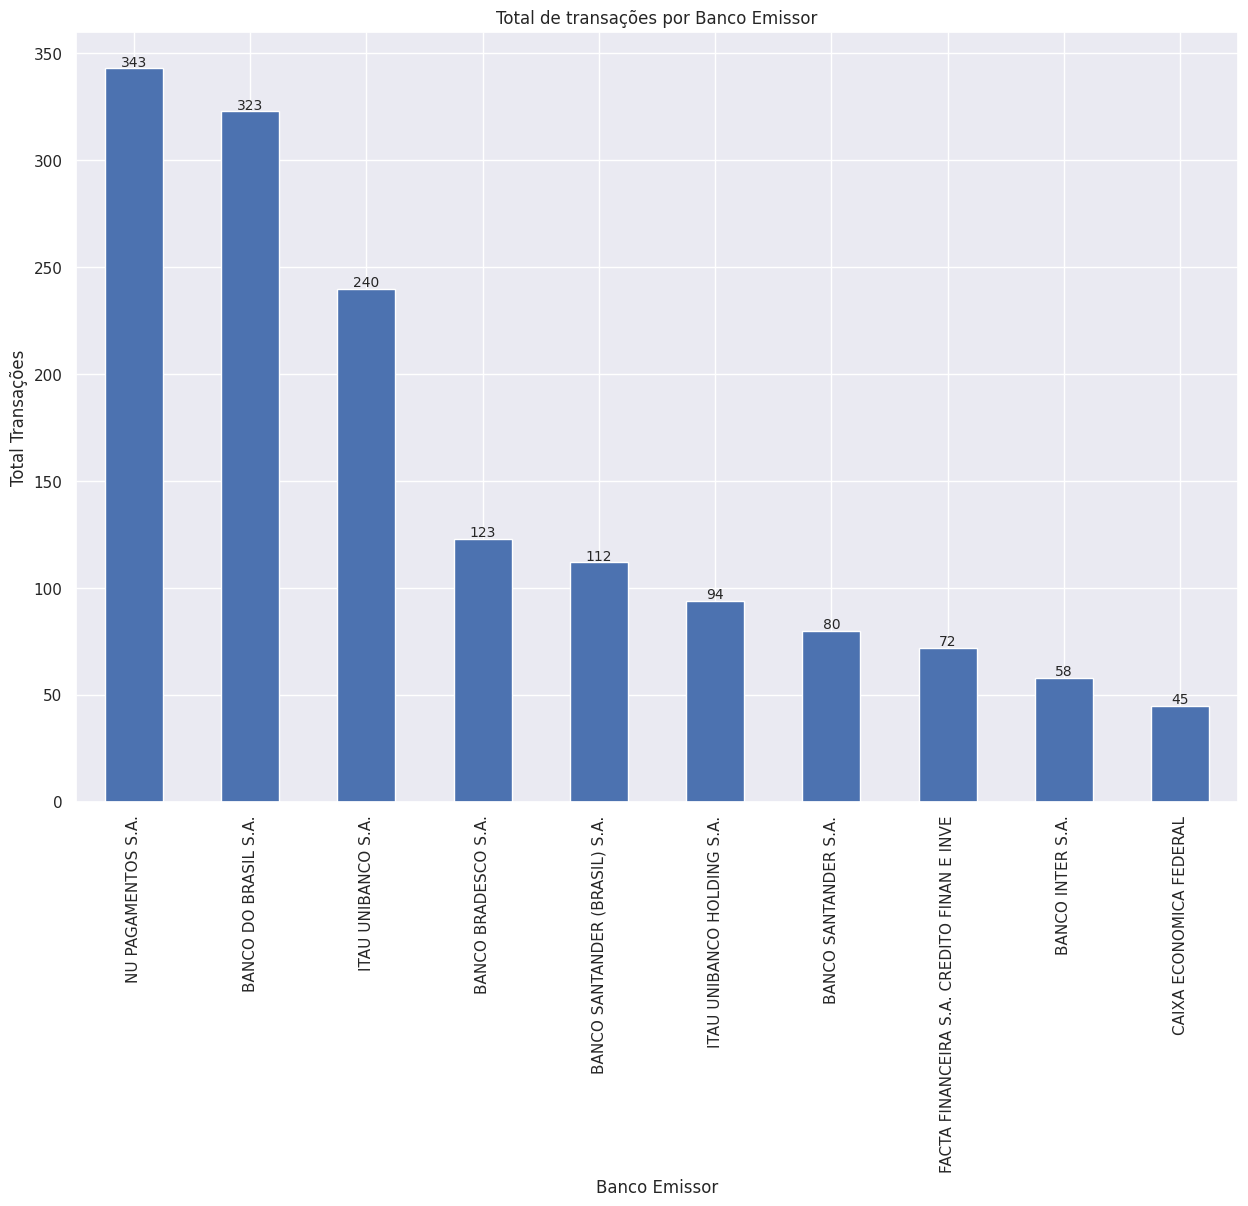

In [ ]:
# Selecting the top 10 banks
top_10_banks = unique_transactions_per_bank_df.sort_values(by='unique_transactions_count', ascending=False).head(10)

sns.set()
plt.figure(figsize=(15, 10))

plt.title('Total de transações por Banco Emissor')

# Plotting the bar graph for top 10 banks
top_10_banks['unique_transactions_count'].plot.bar()

# Annotating each bar with its count
for index, data in enumerate(top_10_banks['unique_transactions_count']):
    plt.text(x=index, y=data + 1, s=f"{data}", fontdict=dict(fontsize=10), ha='center')

# Setting the labels
plt.xlabel('Banco Emissor')
plt.ylabel('Total Transações')

# Set the x-axis labels to be the bank names
plt.xticks(ticks=range(10), labels=top_10_banks['banco_emissor'])

plt.show()

In [ ]:
# status de transacao
unique_transactions_per_bandeira = df_pag_bank.groupby('status_transacao')['transacao_id'].nunique()

unique_transactions_per_bandeira_df = unique_transactions_per_bandeira.reset_index()

unique_transactions_per_bandeira_df.columns = ['status_transacao', 'unique_transactions_count']

unique_transactions_per_bandeira_df.sort_values(by='unique_transactions_count', ascending=False).head()

,status_transacao,unique_transactions_count
1,PAID,1146
0,DECLINED,854


In [ ]:
# mensagem de processamento por numero de transações
unique_transactions_per_mensagem = df_pag_bank.groupby('mensagem_processamento')['transacao_id'].nunique()

unique_transactions_per_mensagem_df = unique_transactions_per_mensagem.reset_index()

unique_transactions_per_mensagem_df.columns = ['mensagem_processamento', 'unique_transactions_count']

unique_transactions_per_mensagem_df.sort_values(by='unique_transactions_count', ascending=False).head(100)

,mensagem_processamento,unique_transactions_count
10,SUCESSO,1146
8,NAO AUTORIZADO PELO PAGSEGURO,238
4,NAO AUTORIZADA,110
0,CONTATE A CENTRAL DO SEU CARTAO,77
15,VERIFIQUE OS DADOS DO CARTAO,75
6,NAO AUTORIZADA - TENTE NOVAMENTE USANDO AUTENT...,68
11,TRANSACAO INVALIDA - NAO TENTE NOVAMENTE,45
12,TRANSACAO NAO PERMITIDA - NAO TENTE NOVAMENTE,41
5,NAO AUTORIZADA - TENTE NOVAMENTE MAIS TARDE,40
9,QTDADE DE TENTATIVAS EXCEDIDAS - NAO TENTE NOV...,36


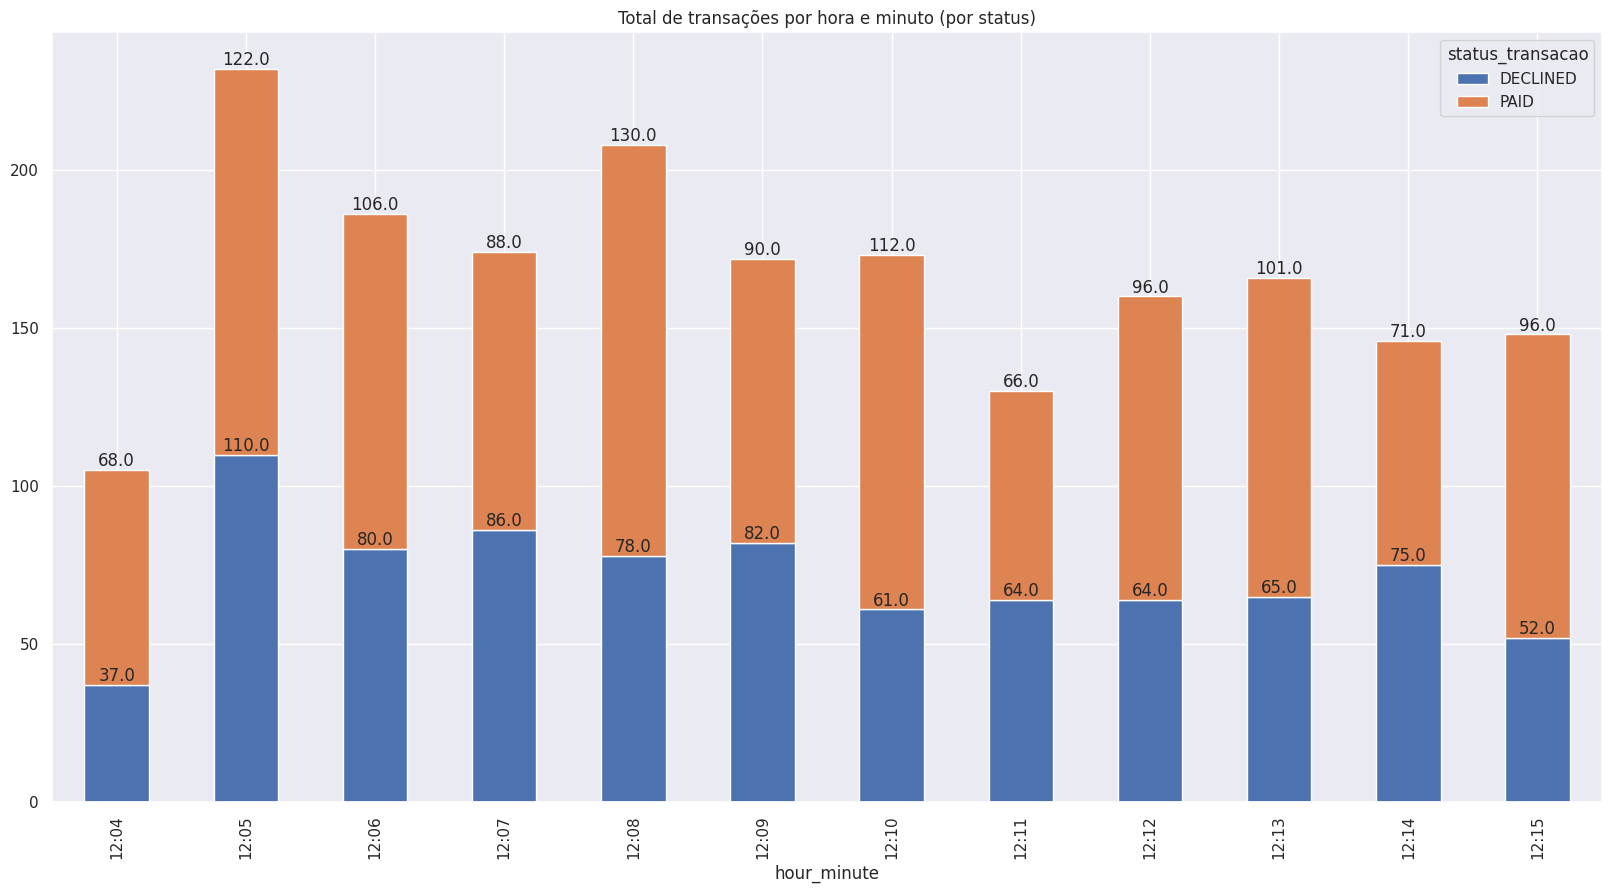

In [ ]:
# Create a new column combining hour and minute
df_pag_bank['hour_minute'] = df_pag_bank['hour'].astype(str) + ':' + df_pag_bank['minutes'].astype(str).str.pad(2, fillchar='0')

# Group by hour-minute and status, then count transactions
transacao_por_hora_minuto_status = df_pag_bank.groupby(['hour_minute', 'status_transacao']).size().unstack(fill_value=0)

# Sort by hour-minute
transacao_por_hora_minuto_status = transacao_por_hora_minuto_status.sort_index()

# Plotting the graph
sns.set()
ax = transacao_por_hora_minuto_status.plot(kind='bar', stacked=True, figsize=(20,10), title='Total de transações por hora e minuto (por status)')

# Adding the number of transactions on top of each bar
for p in ax.patches:
    # Only annotate non-zero values
    if p.get_height() > 0:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                    ha='center', va='bottom')

plt.show()

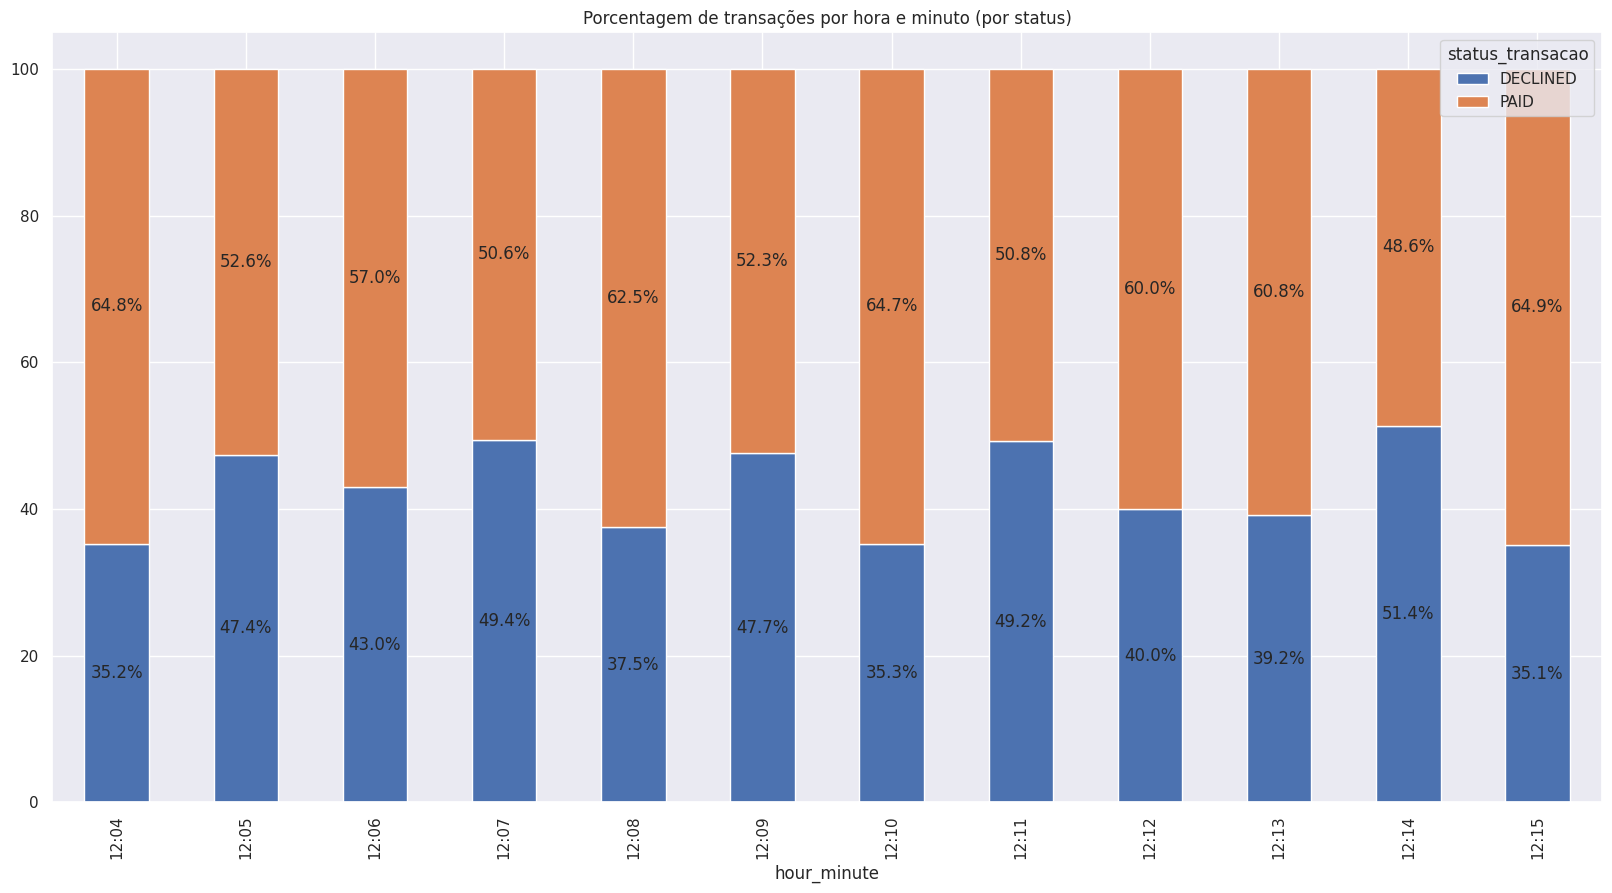

In [ ]:
# Create a new column combining hour and minute
df_pag_bank['hour_minute'] = df_pag_bank['hour'].astype(str) + ':' + df_pag_bank['minutes'].astype(str).str.pad(2, fillchar='0')

# Group by hour-minute and status, then count transactions
transacao_por_hora_minuto_status = df_pag_bank.groupby(['hour_minute', 'status_transacao']).size().unstack(fill_value=0)

# Calculate the percentage of each status for each hour-minute
transacao_percent = transacao_por_hora_minuto_status.div(transacao_por_hora_minuto_status.sum(axis=1), axis=0) * 100

# Sort by hour-minute
transacao_percent = transacao_percent.sort_index()

# Plotting the graph
sns.set()
ax = transacao_percent.plot(kind='bar', stacked=True, figsize=(20,10), title='Porcentagem de transações por hora e minuto (por status)')

# Adding the percentage of transactions on top of each bar
for p in ax.patches:
    # Only annotate non-zero values
    if p.get_height() > 0:
        text = f"{p.get_height():.1f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2),
                    ha='center', va='center')

plt.show()
